In [29]:
#!/usr/bin/env python
# coding: utf-8

# # Modeling
#
# This notebook:
# - Loads processed data
# - Splits data into training and test sets
# - Trains and evaluates Random Forest, XGBoost, and Neural Network models
# - Performs hyperparameter tuning on Random Forest and XGBoost
# - Saves the best-performing models and evaluation metrics

In [3]:
import os
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
print(Path.cwd()) 

# Scikit-learn Modules
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# XGBoost
import xgboost as xgb

# PyTorch Modules
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

/Users/abdurrahman/Documents/Data Bootcamp/Finals/Predicting_Telework_Hours/notebooks


In [4]:
print("Initial Working Directory:", Path.cwd())

# Define the project root explicitly
project_root = Path("/Users/abdurrahman/Documents/Data Bootcamp/Finals/Predicting_Telework_Hours")
os.chdir(project_root)
print("New Working Directory:", os.getcwd())

# Set path to processed data
processed_data_path = project_root / "data" / "processed" / "merged_emp_df_encoded.csv"

# Verify the existence of the processed data file
if not processed_data_path.exists():
    raise FileNotFoundError(f"Processed data file does not exist: {processed_data_path}")

# Load the processed data
merged_emp_df_encoded = pd.read_csv(processed_data_path)
print("Processed Data Loaded Successfully.")


Initial Working Directory: /Users/abdurrahman/Documents/Data Bootcamp/Finals/Predicting_Telework_Hours/notebooks
New Working Directory: /Users/abdurrahman/Documents/Data Bootcamp/Finals/Predicting_Telework_Hours
Processed Data Loaded Successfully.


In [5]:
# Load the scaler
scaler_emp = joblib.load('scaler_emp.pkl')
print("Scaler Loaded Successfully.")

Scaler Loaded Successfully.


In [6]:
# Define the target variable
target_master = 'Avg_Weekly_Hours_Teleworked'
y_master = merged_emp_df_encoded[target_master]

# Define the feature set by excluding the target
X_master = merged_emp_df_encoded.drop([target_master], axis=1)

# Display the shape of features and target
print(f"Features Shape: {X_master.shape}")
print(f"Target Shape: {y_master.shape}")

Features Shape: (74, 87)
Target Shape: (74,)


In [7]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_master, y_master, test_size=0.2, random_state=42
)

print(f"Training Features Shape: {X_train.shape}")
print(f"Testing Features Shape: {X_test.shape}")
print(f"Training Target Shape: {y_train.shape}")
print(f"Testing Target Shape: {y_test.shape}")

Training Features Shape: (59, 87)
Testing Features Shape: (15, 87)
Training Target Shape: (59,)
Testing Target Shape: (15,)


In [8]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf.predict(X_test)

# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest Regressor Performance:")
print(f"Mean Squared Error: {mse_rf:.4f}")
print(f"R-squared: {r2_rf:.4f}")

Random Forest Regressor Performance:
Mean Squared Error: 0.0146
R-squared: 0.9841


In [9]:
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation
cv_scores_rf = cross_val_score(rf, X_train, y_train, cv=5, scoring='r2')

print(f"Random Forest Cross-Validation R-squared Scores: {cv_scores_rf}")
print(f"Mean CV R-squared: {cv_scores_rf.mean():.4f}")
print(f"Standard Deviation of CV R-squared: {cv_scores_rf.std():.4f}")

Random Forest Cross-Validation R-squared Scores: [0.98938528 0.98866665 0.96165223 0.89102202 0.94960555]
Mean CV R-squared: 0.9561
Standard Deviation of CV R-squared: 0.0360


In [9]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize GridSearchCV
grid_search_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='r2'
)

# Perform grid search
grid_search_rf.fit(X_train, y_train)

# Retrieve the best estimator
best_rf = grid_search_rf.best_estimator_

# Display the best parameters
print("Best Parameters for Random Forest:", grid_search_rf.best_params_)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; tot

In [10]:
# Predict with the tuned Random Forest model
y_pred_best_rf = best_rf.predict(X_test)

# Evaluate the tuned model
mse_best_rf = mean_squared_error(y_test, y_pred_best_rf)
r2_best_rf = r2_score(y_test, y_pred_best_rf)

print("Tuned Random Forest Regressor Performance:")
print(f"Mean Squared Error: {mse_best_rf:.4f}")
print(f"R-squared: {r2_best_rf:.4f}")

Tuned Random Forest Regressor Performance:
Mean Squared Error: 0.0160
R-squared: 0.9825


In [11]:
# Save the tuned Random Forest model
joblib.dump(best_rf, 'tuned_random_forest_telework_model.pkl')

print("Random Forest model saved successfully as 'tuned_random_forest_telework_model.pkl'.")

Random Forest model saved successfully as 'tuned_random_forest_telework_model.pkl'.


In [12]:
# Initialize the XGBoost Regressor
xgb_reg = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)

# Train the model
xgb_reg.fit(X_train, y_train)

# Predict on the test set
y_pred_xgb = xgb_reg.predict(X_test)

# Evaluate the model
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("XGBoost Regressor Performance:")
print(f"Mean Squared Error: {mse_xgb:.4f}")
print(f"R-squared: {r2_xgb:.4f}")

XGBoost Regressor Performance:
Mean Squared Error: 0.0286
R-squared: 0.9688


In [17]:
# Save the tuned XGBoost model
joblib.dump(y_pred_xgb, 'tuned_xgboost_telework_model.pkl')

print("XGBoost model saved successfully as 'tuned_xgboost_telework_model.pkl'.")


XGBoost model saved successfully as 'tuned_xgboost_telework_model.pkl'.


In [15]:

# === Preprocessing ===

# Standardize features
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Convert categorical columns to dummy variables (one-hot encoding)
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# Align train and test features
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Fill missing values (if any)
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

# Convert boolean columns to integers (0 and 1)
X_train = X_train.astype({col: 'int64' for col in X_train.select_dtypes(include=['bool']).columns})
X_test = X_test.astype({col: 'int64' for col in X_test.select_dtypes(include=['bool']).columns})

# Ensure target variables are numeric
y_train = pd.to_numeric(y_train, errors='coerce').fillna(0)
y_test = pd.to_numeric(y_test, errors='coerce').fillna(0)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)

X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Create TensorDataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# === Define Neural Network ===

class TeleworkNet(nn.Module):
    def __init__(self, input_dim):
        super(TeleworkNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

# Initialize the model
input_dim = X_train.shape[1]
model = TeleworkNet(input_dim)

# Define the loss function and optimizer with weight decay (L2 regularization)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

# === Training ===

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    epoch_losses = []

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(batch_X)  # Forward pass
        loss = criterion(outputs, batch_y)  # Loss calculation
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        epoch_losses.append(loss.item())

    # Step the scheduler
    scheduler.step()

    # Calculate average loss for the epoch
    avg_loss = np.mean(epoch_losses)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}")

# === Evaluation ===

model.eval()
test_losses = []
predictions = []
targets = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X).squeeze()
        loss = criterion(outputs, batch_y)
        test_losses.append(loss.item())

        predictions.extend(outputs.numpy())
        targets.extend(batch_y.numpy())

# Calculate average test loss
avg_test_loss = np.mean(test_losses)
print(f"Test Loss: {avg_test_loss:.4f}")

# R-squared score
r2 = r2_score(targets, predictions)
print(f"R-squared: {r2:.4f}")

# Mean Squared Error
mse = mean_squared_error(targets, predictions)
print(f"Mean Squared Error: {mse:.4f}")


Epoch [10/100], Loss: 0.5414
Epoch [20/100], Loss: 0.0773
Epoch [30/100], Loss: 0.0208
Epoch [40/100], Loss: 0.0058
Epoch [50/100], Loss: 0.0027
Epoch [60/100], Loss: 0.0015
Epoch [70/100], Loss: 0.0010
Epoch [80/100], Loss: 0.0007
Epoch [90/100], Loss: 0.0006
Epoch [100/100], Loss: 0.0005
Test Loss: 1.5685
R-squared: 0.9429
Mean Squared Error: 0.0523


/Users/abdurrahman/.pyenv/versions/3.11.5/lib/python3.11/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([15, 1])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [16]:
# Save the model's state dictionary
torch.save(model.state_dict(), 'telework_neural_network_model.pth')

print("PyTorch Neural Network model saved successfully as 'telework_neural_network_model.pth'.")

PyTorch Neural Network model saved successfully as 'telework_neural_network_model.pth'.


In [18]:
# Initialize the model architecture
model_loaded = TeleworkNet(input_dim)

# Load the saved state dictionary
model_loaded.load_state_dict(torch.load('telework_neural_network_model.pth'))
model_loaded.eval()

# Example: Predict on a single data point
sample = X_test.iloc[0].values.reshape(1, -1)
sample_tensor = torch.tensor(sample, dtype=torch.float32)

with torch.no_grad():
    prediction = model_loaded(sample_tensor).item()

print(f"Predicted Avg Weekly Hours Teleworked: {prediction:.4f}")
print(f"Actual Avg Weekly Hours Teleworked: {y_test.iloc[0]:.4f}")

Predicted Avg Weekly Hours Teleworked: 1.1941
Actual Avg Weekly Hours Teleworked: 1.3488


/var/folders/xw/ty4mctf512x2tmfd8_j6htqc0000gn/T/ipykernel_83822/3585079874.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_loaded.load_state_dict(torch.load('tele

In [21]:
# Calculate MAE for Random Forest
mae_rf = mean_absolute_error(y_test, y_pred_rf)

# Calculate MAE for XGBoost
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

# Calculate MAE for Neural Network
mae_nn = mean_absolute_error(targets, predictions)

# Compile the performance metrics including MAE
performance = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost', 'Neural Network'],
    'Mean Squared Error': [mse_rf, mse_xgb, mse],
    'Mean Absolute Error': [mae_rf, mae_xgb, mae_nn],
    'R-squared': [r2_rf, r2_xgb, r2]
})

print("--- Model Performance Comparison ---")
print(performance)

--- Model Performance Comparison ---
            Model  Mean Squared Error  Mean Absolute Error  R-squared
0   Random Forest            0.014608             0.098295   0.984060
1         XGBoost            0.028601             0.120303   0.968792
2  Neural Network            0.052301             0.184490   0.942931


In [24]:

actuals = np.array(targets).flatten()


In [25]:
targets = np.array(y_test)  
comparison = pd.DataFrame({
    'Actual': targets,
    'Random Forest': y_pred_rf,
    'XGBoost': y_pred_xgb,
    'Neural Network': predictions
})

In [26]:
print(comparison.head())
print(comparison.dtypes)


     Actual  Random Forest   XGBoost  Neural Network
0  1.348771       1.101458  0.875534        1.194122
1 -0.563122      -0.515633 -0.541395       -0.642169
2 -0.974282      -1.027733 -0.984708       -0.819814
3 -0.008057      -0.002095 -0.006317        0.200606
4 -1.056514      -1.079745 -1.038434       -0.761537
Actual            float64
Random Forest     float64
XGBoost           float32
Neural Network    float32
dtype: object


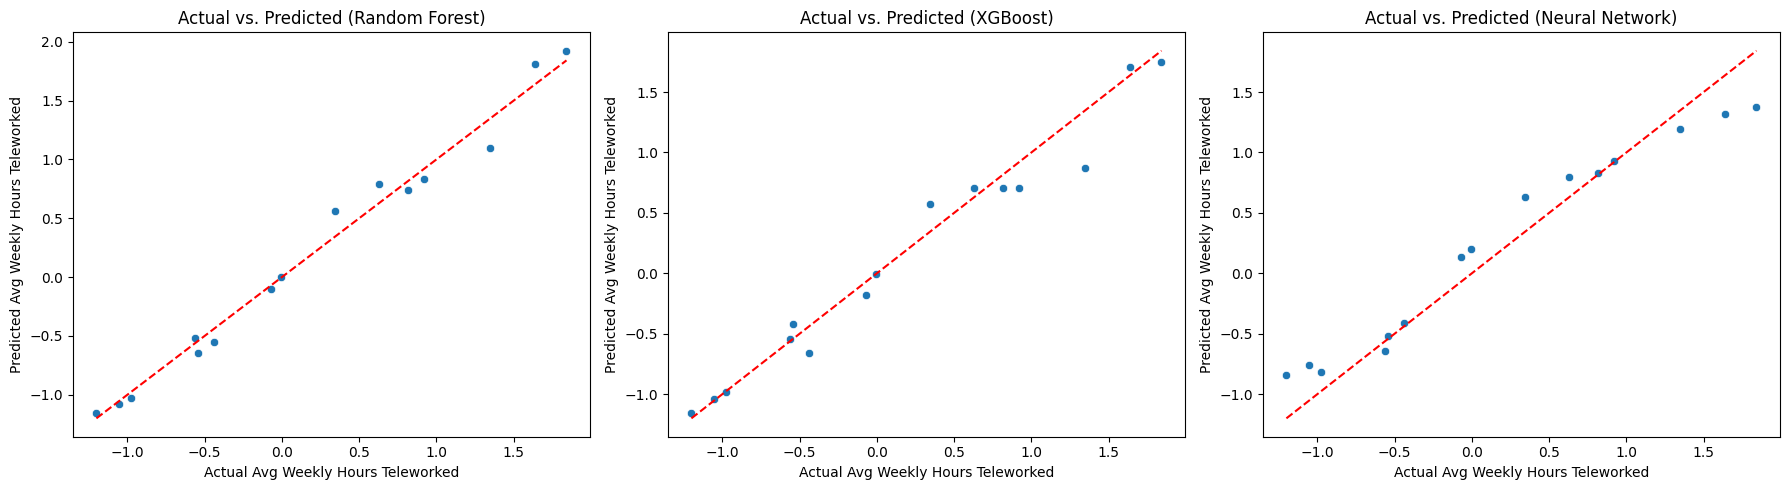

In [27]:
# Ensure all columns in the comparison DataFrame are float64
comparison = comparison.astype('float64')

# Plot Actual vs. Predicted for each model
plt.figure(figsize=(18, 5))

models = ['Random Forest', 'XGBoost', 'Neural Network']
for i, model in enumerate(models, 1):
    plt.subplot(1, 3, i)
    sns.scatterplot(x='Actual', y=model, data=comparison)
    plt.plot([comparison['Actual'].min(), comparison['Actual'].max()],
             [comparison['Actual'].min(), comparison['Actual'].max()],
             color='red', linestyle='--')
    plt.title(f'Actual vs. Predicted ({model})')
    plt.xlabel('Actual Avg Weekly Hours Teleworked')
    plt.ylabel('Predicted Avg Weekly Hours Teleworked')

plt.tight_layout()
plt.savefig('actual_vs_predicted_comparison.png')  # Save the figure
plt.show()


In [28]:
# Save the training and testing sets
processed_data_path = project_root / "data" / "processed"
os.makedirs(processed_data_path, exist_ok=True)

# Save training and testing data
joblib.dump(X_train, processed_data_path / "X_train.pkl")
joblib.dump(X_test, processed_data_path / "X_test.pkl")
joblib.dump(y_train, processed_data_path / "y_train.pkl")
joblib.dump(y_test, processed_data_path / "y_test.pkl")

print("Training and testing data saved successfully.")


Training and testing data saved successfully.
